In [1]:
import pickle
from collections import defaultdict, Counter
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
congress_trigram_dates = json.load(open('congress_tri_dates.json', 'r'))
news_trigram_dates = json.load(open('news_tri_dates.json', 'r'))
new_pearsons = json.load(open('new_tri_pearsons.json', 'r'))

In [3]:
congress_trigram_dates

{'even difficult time': {'d_dates': [57,
   72,
   77,
   260,
   512,
   525,
   609,
   2201,
   2248,
   2270,
   2458,
   2605,
   2731,
   2745,
   2760,
   2870,
   2872],
  'r_dates': [0, 92, 239, 547, 624, 2240, 2303, 2445, 2905]},
 'chairman hous republican': {'d_dates': [63,
   442,
   443,
   443,
   2963,
   3012,
   3089,
   3199,
   3369,
   3369,
   3538],
  'r_dates': [0,
   63,
   72,
   149,
   253,
   477,
   512,
   2964,
   2985,
   3020,
   3124,
   3128,
   3236,
   3256,
   3313,
   3319,
   3368,
   3368,
   3369,
   3480]},
 'express profound gratitud': {'d_dates': [0,
   50,
   72,
   392,
   441,
   500,
   554,
   559,
   639,
   918,
   988,
   1065,
   1114],
  'r_dates': [36, 73, 135, 750, 771, 1037, 1045, 1203, 1268]},
 'serv peopl hous': {'d_dates': [0, 128, 335],
  'r_dates': [287, 303, 471, 512, 512, 512, 512, 512]},
 'us creat job': {'d_dates': [0,
   127,
   128,
   135,
   426,
   476,
   491,
   547,
   2201,
   2225,
   2304,
   2318,
   2534,
 

In [4]:
def smooth(arr, K):
    smoothed_arr = []
    for i, _ in enumerate(arr):
        low = max(0, i - K//2)
        high = min(i + K//2 + 1, len(arr))
        window = arr[low:high]
        smoothed_value = sum(window) / len(window)
        smoothed_arr.append(smoothed_value)
    return smoothed_arr

# compute averages of the democratic and republican trigram counts for each day
def average_phrases(trigram_dates):
    num_phrases = len(trigram_dates)
    d_counters = [Counter(date_dict['d_dates']) for date_dict in trigram_dates.values()]
    r_counters = [Counter(date_dict['r_dates']) for date_dict in trigram_dates.values()]
    d_counts = {k: v/num_phrases for k, v in sum(d_counters, Counter()).items()}
    r_counts = {k: v/num_phrases for k, v in sum(r_counters, Counter()).items()}
    d_x, d_y = zip(*sorted(d_counts.items()))
    r_x, r_y = zip(*sorted(r_counts.items()))
    return np.array(d_x), np.array(d_y), np.array(r_x), np.array(r_y)

def preprocess_congress(current_session, num_phrases, party):
    sorted_pearsons = sorted(new_pearsons[str(current_session)].items(), key = lambda kv: kv[1])
    pearsons = sorted_pearsons[:num_phrases] if party == 'D' else sorted_pearsons[-num_phrases:]
    congress_dates = {trigram: congress_trigram_dates[trigram] for trigram, score in pearsons}
    return average_phrases(congress_dates)

def preprocess_news(current_session, num_phrases, party):
    sorted_pearsons = sorted(new_pearsons[str(current_session)].items(), key = lambda kv: kv[1])
    pearsons = sorted_pearsons[:num_phrases] if party == 'D' else sorted_pearsons[-num_phrases:]
    news_dates = {trigram: news_trigram_dates[trigram] for trigram, score in pearsons}
    return average_phrases(news_dates)

In [6]:
def full_visualizations(current_session, num_phrases):
    plt.figure(figsize=(20,10))
    for party in ('D', 'R'):
        congress_d_x, congress_d_y, congress_r_x, congress_r_y = preprocess_congress(current_session, num_phrases, party)
        d_y_mean = [np.mean(congress_d_y[np.where((-30 <= congress_d_x) & (congress_d_x <= 200))])]*len(congress_d_x)
        r_y_mean = [np.mean(congress_r_y[np.where((-30 <= congress_r_x) & (congress_r_x <= 200))])]*len(congress_r_x)
        plt.subplot(2, 2, (party == 'R')+1)
        party_label = 'Liberal' if party == 'D' else 'Conservative'
        plt.title('Session ' + str(current_session) + ': Use of Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams in Congress Over Time')
        plt.plot(congress_d_x, smooth(congress_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
        plt.plot(congress_r_x, smooth(congress_r_y, 5), color = 'r')
        plt.plot(congress_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
        plt.plot(congress_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
        plt.legend(['Congress Liberal', 'Congress Conservative'], loc = 'upper right')
        #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
        plt.xlabel('Number of Days Away From First Day Trigram Spoken in Congress')
        plt.ylabel('Number of Times Average Trigram Used per Day')
        plt.xlim((-30, 200))
        plt.ylim((0, 1))

    for party in ('D', 'R'):
        news_d_x, news_d_y, news_r_x, news_r_y = preprocess_news(current_session, num_phrases, party)
        d_y_mean = [np.mean(news_d_y[np.where((-30 <= news_d_x) & (news_d_x <= 200))])]*len(news_d_x)
        r_y_mean = [np.mean(news_r_y[np.where((-30 <= news_r_x) & (news_r_x <= 200))])]*len(news_r_x)
        plt.subplot(2, 2, (party == 'R')+3)
        party_label = 'Liberal' if party == 'D' else 'Conservative'
        plt.title('Session ' + str(current_session) + ': Use of Top ' + str(num_phrases) + ' ' + party_label + ' Trigrams in News Over Time')
        plt.plot(news_d_x, smooth(news_d_y, 5), color = 'b', zorder = 2*(party == 'R') + 1)
        plt.plot(news_r_x, smooth(news_r_y, 5), color = 'r')
        plt.plot(news_d_x,d_y_mean, label='Mean', linestyle='--', color = 'b', alpha=0.5)
        plt.plot(news_r_x,r_y_mean, label='Mean', linestyle='--', color = 'r', alpha=0.5)
        # dashed lines
        plt.legend(['News Liberal', 'News Conservative'], loc = 'upper right')
        #     plt.xticks(range(min(news_d_x), max(news_d_x)+1, 365))
        plt.xlabel('Number of Days Away From First Day Trigram Spoken in Congress')
        plt.ylabel('Number of Times Average Trigram Used per Day')
        plt.xlim((-30, 200))
        plt.ylim((0, 0.2))

    plt.show()

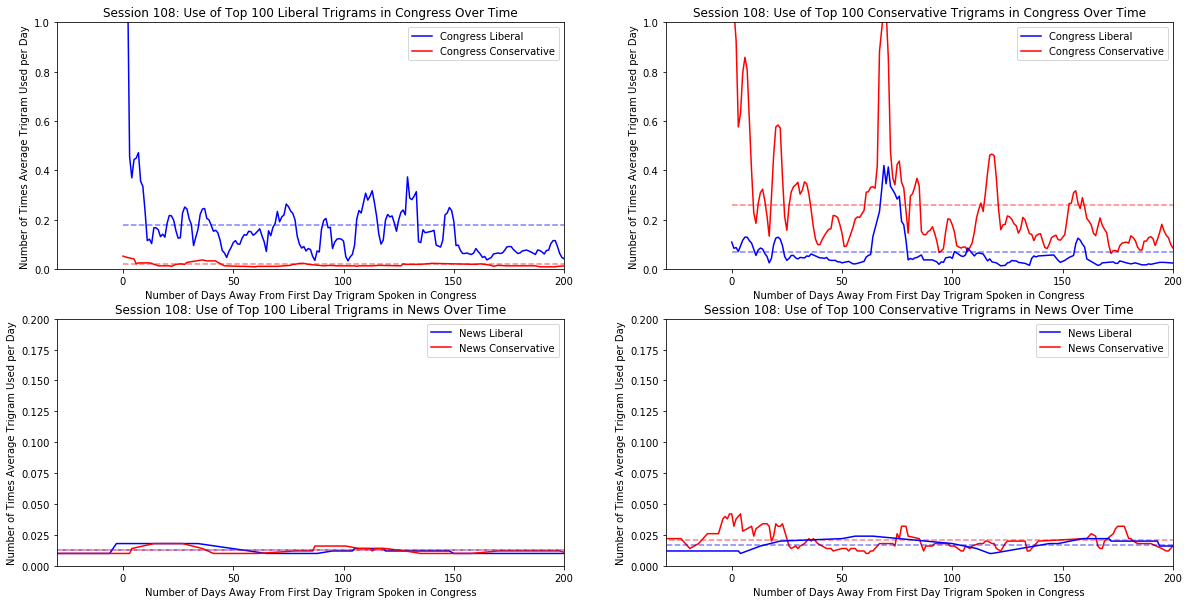

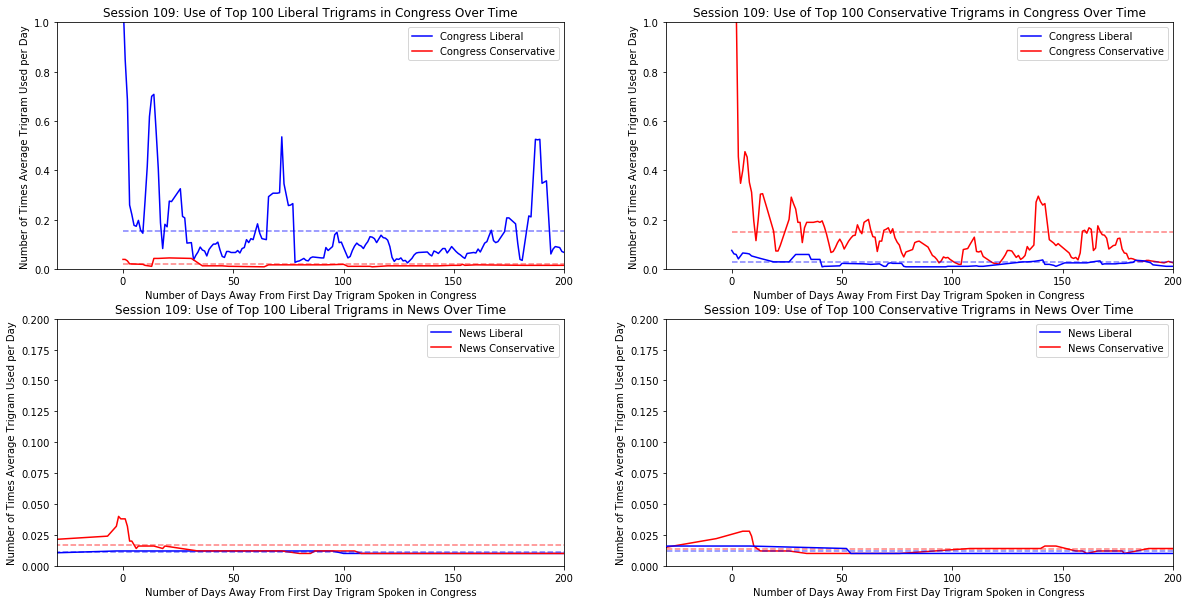

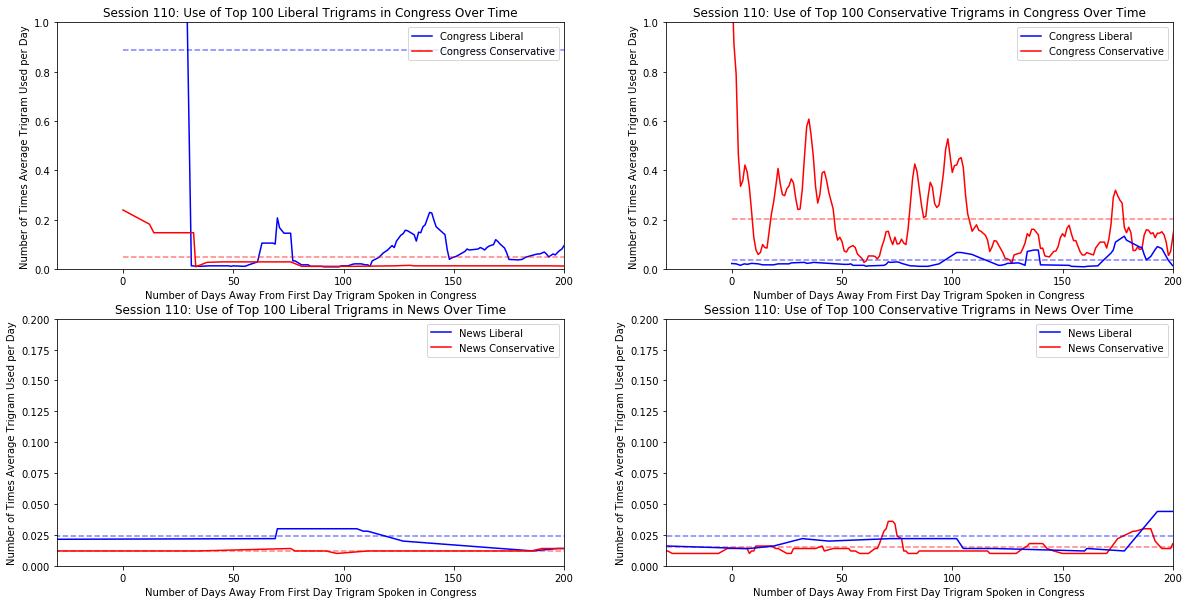

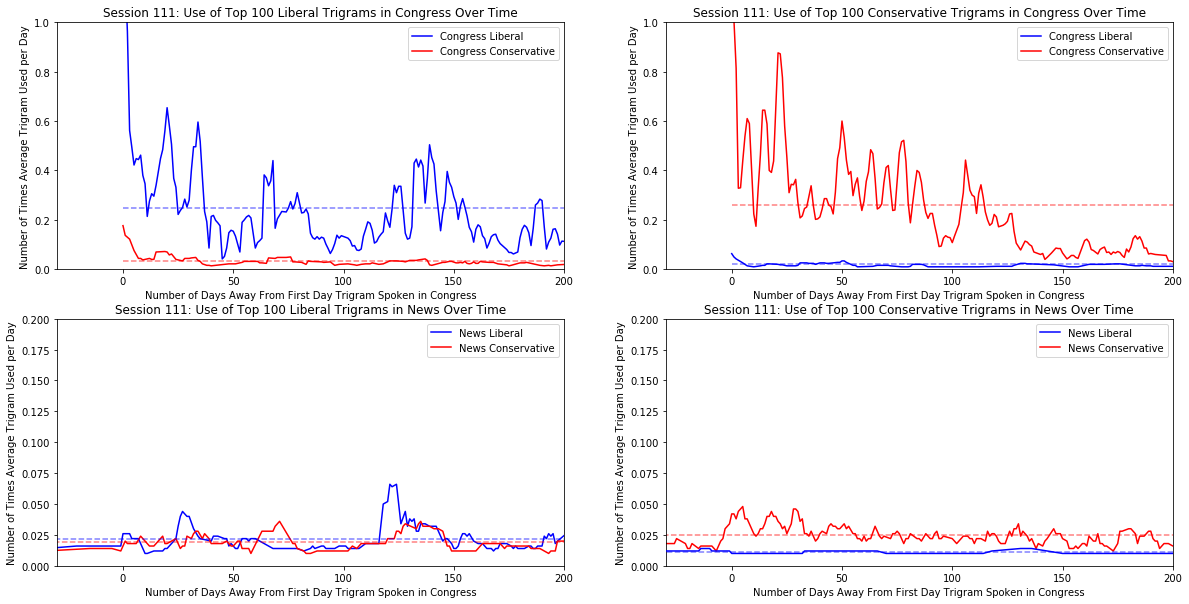

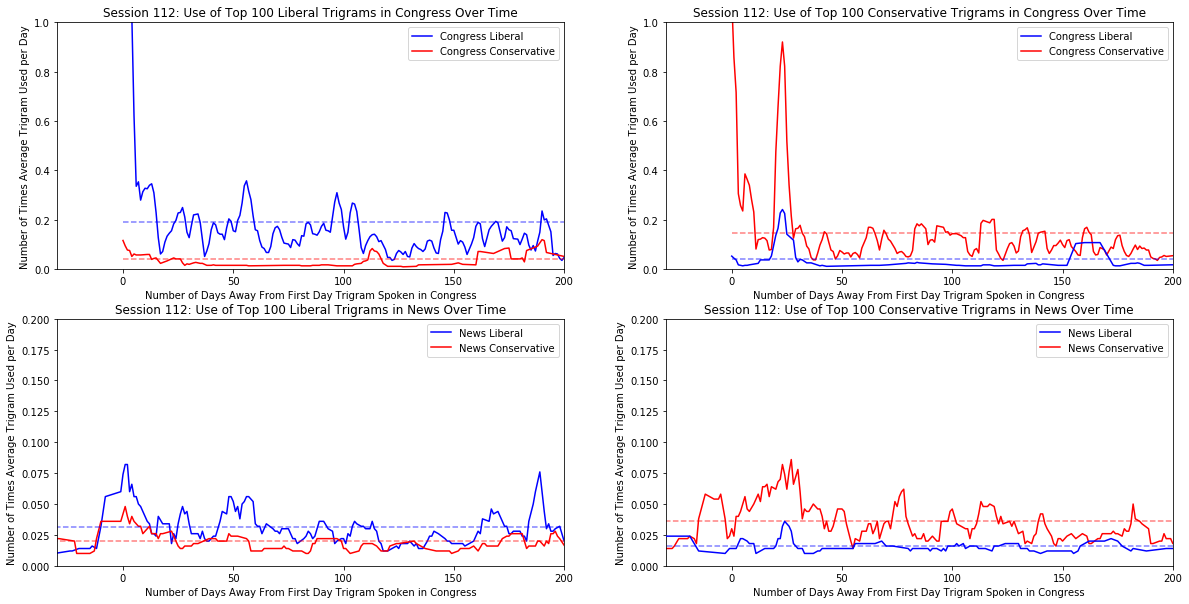

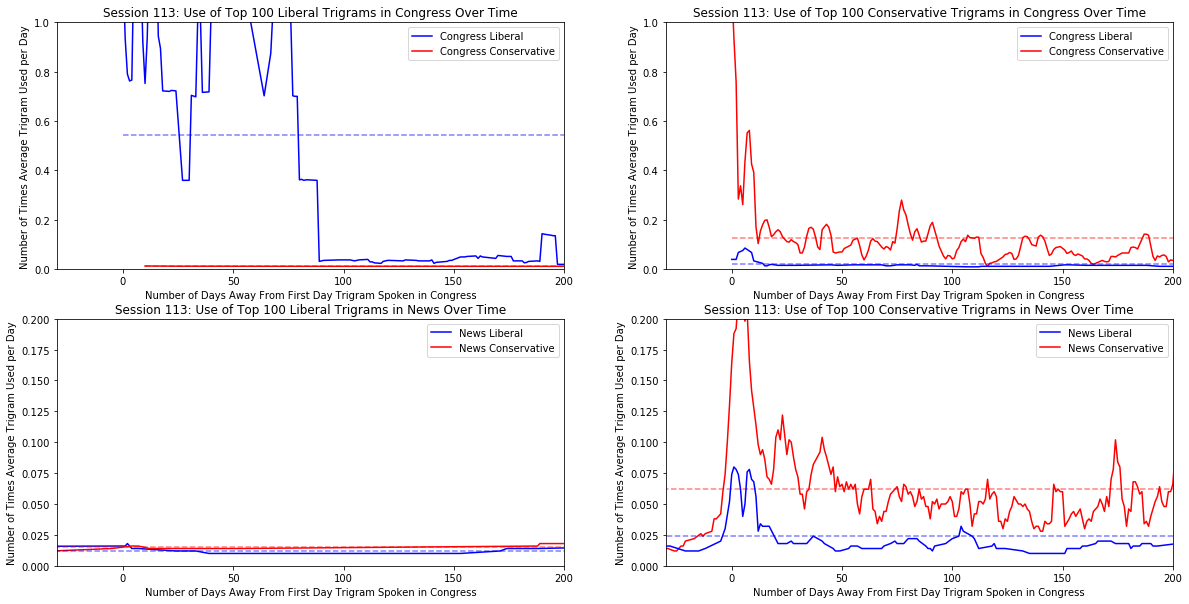

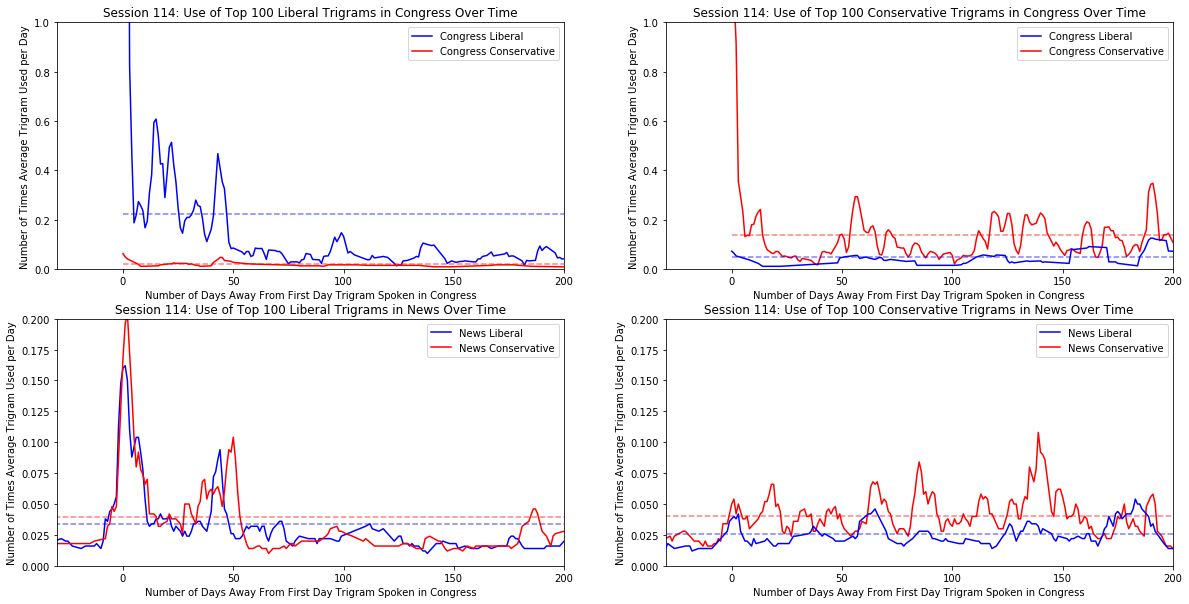

In [7]:
num_phrases = 100
for current_session in range(108,115):
    full_visualizations(current_session, num_phrases)